# Importy

In [1]:
import pandas as pd
from google.colab import drive
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from datetime import datetime
from datetime import timedelta

# Ładowanie i przygotowanie danych, wstępna analiza

Mounted at /content/drive
Liczba rekordów w zbiorze treningowym: 59999
Liczba cech w zbiorze treningowym: 784
Liczba rekordów w zbiorze testowym: 9999
Liczba cech w zbiorze testowym: 784
Rozkład kategorii(%):
class
1    11.236854
7    10.441841
3    10.218504
2     9.930166
9     9.915165
0     9.871831
6     9.863498
8     9.751829
4     9.736829
5     9.033484
Name: proportion, dtype: float64


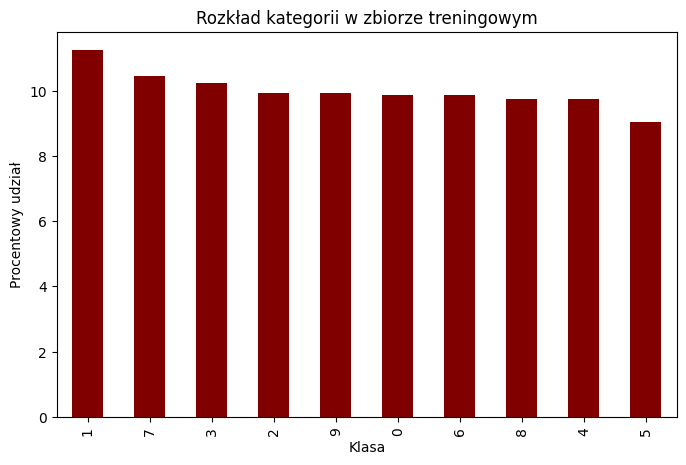

In [3]:
# ładowanie i podział danych
drive.mount('/content/drive')
path = '/content/drive/MyDrive/pro1d/'
mnist_train = pd.read_csv(path + 'mnist_train.csv', header='infer')
mnist_test = pd.read_csv(path + 'mnist_test.csv', header='infer')

# dodanie nazw kolumn
column_names = ['class'] + [f'pixel{i}' for i in range(1, 785)]
mnist_train.columns = column_names
mnist_test.columns = column_names

x_train = mnist_train.drop(columns='class')
y_train = mnist_train['class']

x_test = mnist_test.drop(columns='class')
y_test = mnist_test['class']

# liczba rekordów i cech w zbiorze treningowym i testowym
train_records = mnist_train.shape[0]
train_features = mnist_train.shape[1] - 1

test_records = mnist_test.shape[0]
test_features = mnist_test.shape[1] - 1

print(f"Liczba rekordów w zbiorze treningowym: {train_records}")
print(f"Liczba cech w zbiorze treningowym: {train_features}")
print(f"Liczba rekordów w zbiorze testowym: {test_records}")
print(f"Liczba cech w zbiorze testowym: {test_features}")

# rozkład kategorii(%)
class_distribution = mnist_train['class'].value_counts(normalize=True) * 100
print("Rozkład kategorii(%):")
print(class_distribution)

# wykres słupkowy dla rozkładu kategorii
plt.figure(figsize=(8, 5))
class_distribution.plot(kind='bar', color='maroon')
plt.title("Rozkład kategorii w zbiorze treningowym")
plt.xlabel("Klasa")
plt.ylabel("Procentowy udział")
plt.show()



# Wizualizacja (litery)

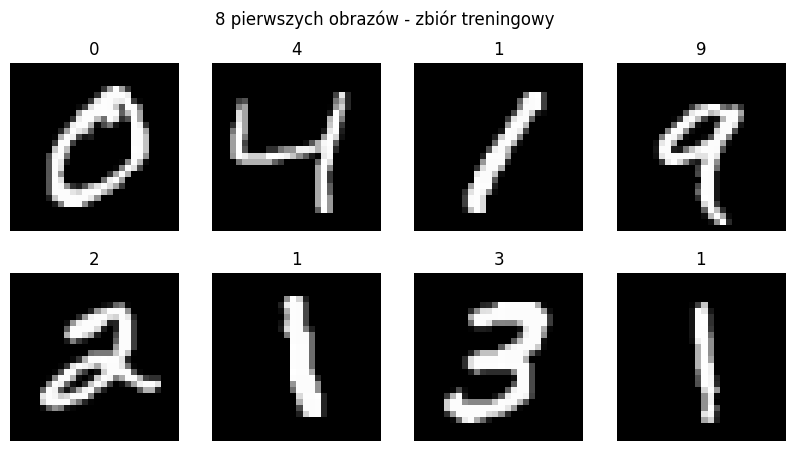

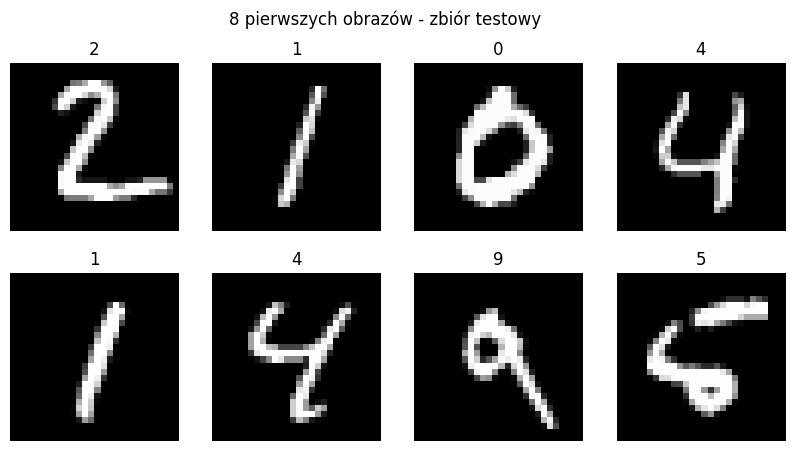

In [4]:
train_images = mnist_train.iloc[:8, 1:].values
train_labels = mnist_train.iloc[:8, 0].values

test_images = mnist_test.iloc[:8, 1:].values
test_labels = mnist_test.iloc[:8, 0].values

def plot_images(images, labels, title):
    plt.figure(figsize=(10, 5))
    for i in range(8):
        plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].reshape(28, 28), cmap='gray')
        plt.title(labels[i])
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

plot_images(train_images, train_labels, '8 pierwszych obrazów - zbiór treningowy')
print()
plot_images(test_images, test_labels, '8 pierwszych obrazów - zbiór testowy')

# Tworzenie klasyfikatora Decision tree

In [5]:
model = DecisionTreeClassifier(random_state=42)
model.fit(x_train, y_train)

y_pred = model.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)

print(f'Dokładność DT: {accuracy:.4f}')

Dokładność DT: 0.8778


# Optymalizacja hyperparametrów DT, ręczne ustawienie parametrów.


In [6]:
max_depth_values = [20, 30]
criterions = ['gini', 'entropy', 'log_loss']

best_accuracy = 0
best_params = {}

for max_depth in max_depth_values:
    for criterion in criterions:
        model = DecisionTreeClassifier(max_depth=max_depth, criterion=criterion, random_state=42)
        model.fit(x_train, y_train)

        y_pred = model.predict(x_test)
        accuracy = accuracy_score(y_test, y_pred)

        print(f"max_depth={max_depth}, criterion={criterion} => Accuracy: {accuracy:.4f}")
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = {
                'max_depth': max_depth,
                'criterion': criterion
            }

print("Najlepsza dokładność:", best_accuracy)
print("Najlepsze parametry:", best_params)

model = DecisionTreeClassifier(max_depth=best_params['max_depth'], criterion=best_params['criterion'], random_state=42)
model.fit(x_train, y_train)


max_depth=20, criterion=gini => Accuracy: 0.8836
max_depth=20, criterion=entropy => Accuracy: 0.8867
max_depth=20, criterion=log_loss => Accuracy: 0.8867
max_depth=30, criterion=gini => Accuracy: 0.8783
max_depth=30, criterion=entropy => Accuracy: 0.8855
max_depth=30, criterion=log_loss => Accuracy: 0.8855
Najlepsza dokładność: 0.8866886688668867
Najlepsze parametry: {'max_depth': 20, 'criterion': 'entropy'}


DecisionTreeClassifier(criterion='entropy', max_depth=20, random_state=42)

# Wizualizacja drzewa i 5 najważniejszych atrybutów

5 najważniejszych atrybutów:
      feature  importance
461  pixel462    0.095196
378  pixel379    0.094822
401  pixel402    0.068546
542  pixel543    0.047722
597  pixel598    0.033596


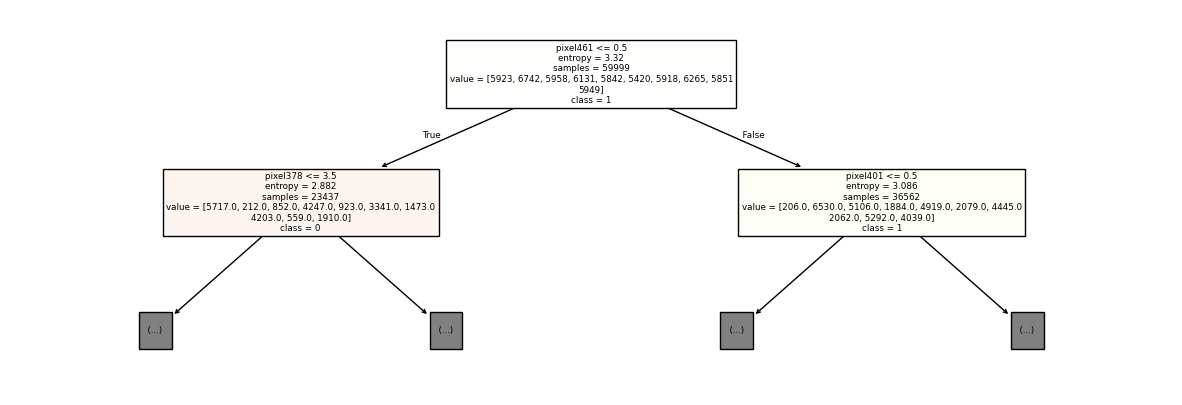

In [7]:
# 5 najważniejszych atrybuów
feature_importances = model.feature_importances_

feature_importance_df = pd.DataFrame({
    'feature': x_train.columns,
    'importance': feature_importances
})

feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

print("5 najważniejszych atrybutów:")
print(feature_importance_df.head(5))

# wizualizacja drzewa
fig = plt.figure(figsize=(15,5))
f_names = list(mnist_train.columns.values.tolist())
t_names = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
tree.plot_tree(model, max_depth =1, feature_names = f_names,
                   class_names=t_names, filled = True)
plt.show()

# Trenowanie zespołu klasyfikatorów RandomForest z optymalizacją parametrów.

n_estimators=150, max_depth=20, accuracy=0.9690969096909691
n_estimators=150, max_depth=30, accuracy=0.96999699969997
Dokładność na zbiorze testowym: 0.970


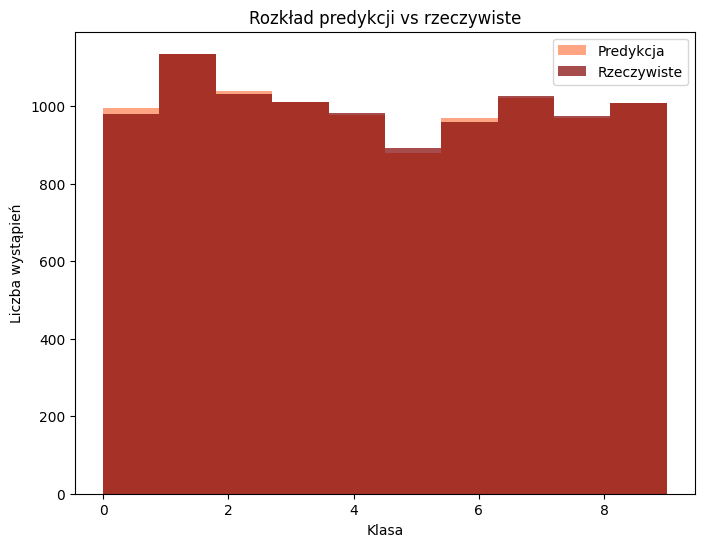

In [8]:
best_accuracy = 0
best_max_depth=0

for max_depth in [20, 30]:
    rf_clf = RandomForestClassifier(n_estimators=150, max_depth=max_depth, random_state=42)
    rf_clf.fit(x_train, y_train)
    y_pred = rf_clf.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"n_estimators=150, max_depth={max_depth}, accuracy={accuracy}")

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_max_depth = max_depth


rf_clf = RandomForestClassifier(n_estimators=150, max_depth=best_max_depth, random_state=42)
rf_clf.fit(x_train, y_train)

# klasyfikacja
y_pred = rf_clf.predict(x_test)

test_accuracy = accuracy_score(y_test, y_pred)
print(f"Dokładność na zbiorze testowym: {test_accuracy:.3f}")

# wizualizacja
plt.figure(figsize=(8, 6))
plt.hist(y_pred, bins=len(set(y_test)), alpha=0.7, label='Predykcja', color='coral')
plt.hist(y_test, bins=len(set(y_test)), alpha=0.7, label='Rzeczywiste', color='maroon')
plt.legend()
plt.title("Rozkład predykcji vs rzeczywiste")
plt.xlabel("Klasa")
plt.ylabel("Liczba wystąpień")
plt.show()

# Trenowanie zespołu klasyfikatorów ExtraTree z optymalizacją parametrów.

n_estimators=150, max_depth=20, accuracy=0.971
n_estimators=150, max_depth=30, accuracy=0.972
Dokładność na zbiorze testowym: 0.972


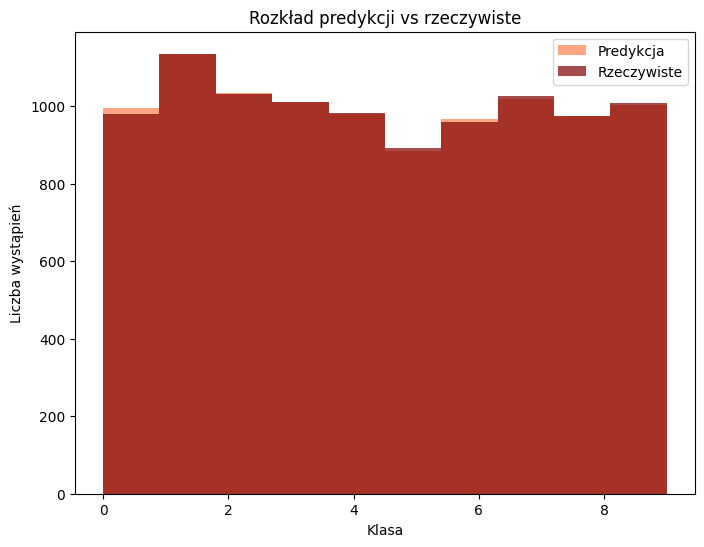

In [9]:
best_accuracy = 0
best_max_depth = 0

for max_depth in [20, 30]:
    et_clf = ExtraTreesClassifier(n_estimators=150, max_depth=max_depth, random_state=42)
    et_clf.fit(x_train, y_train)
    y_pred = et_clf.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"n_estimators=150, max_depth={max_depth}, accuracy={accuracy:.3f}")

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_max_depth = max_depth

et_clf = ExtraTreesClassifier(n_estimators=150, max_depth=best_max_depth, random_state=42)
et_clf.fit(x_train, y_train)

# klasyfikacja
y_pred = et_clf.predict(x_test)

test_accuracy = accuracy_score(y_test, y_pred)
print(f"Dokładność na zbiorze testowym: {test_accuracy:.3f}")

# wizualizacja
plt.figure(figsize=(8, 6))
plt.hist(y_pred, bins=len(set(y_test)), alpha=0.7, label='Predykcja', color='coral')
plt.hist(y_test, bins=len(set(y_test)), alpha=0.7, label='Rzeczywiste', color='maroon')
plt.legend()
plt.title("Rozkład predykcji vs rzeczywiste")
plt.xlabel("Klasa")
plt.ylabel("Liczba wystąpień")
plt.show()


# Trenowanie zespołu klasyfikatorów XGBoost z optymalizacją parametrów.

n_estimators=150, max_depth=5, accuracy=0.980
n_estimators=150, max_depth=7, accuracy=0.980
Dokładność: 0.980


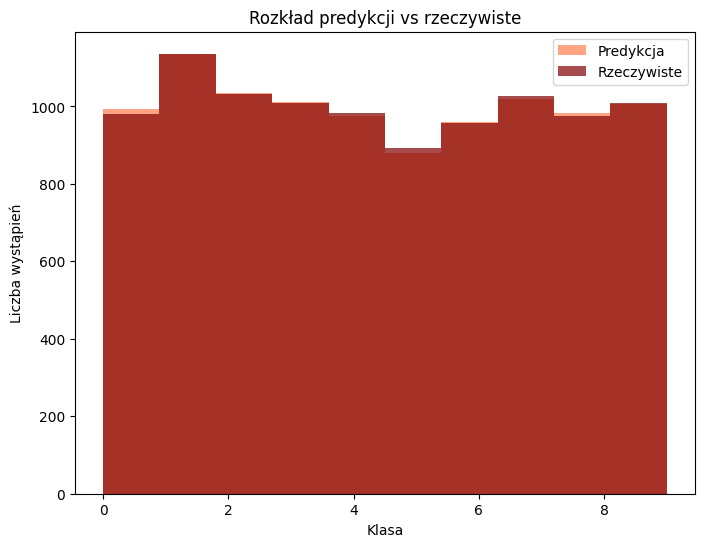

In [ ]:
best_accuracy = 0
best_max_depth = 0

for max_depth in [5, 7]:
    xgb_clf = XGBClassifier(n_estimators=150, max_depth=max_depth, random_state=42, eval_metric='mlogloss')
    xgb_clf.fit(x_train, y_train)
    y_pred = xgb_clf.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)

    print(f"n_estimators=150, max_depth={max_depth}, accuracy={accuracy:.3f}")

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_max_depth = max_depth


xgb_clf = XGBClassifier(n_estimators=150, max_depth=best_max_depth, random_state=42, eval_metric='mlogloss')
xgb_clf.fit(x_train, y_train)

# klasyfikacja
y_pred = xgb_clf.predict(x_test)

test_accuracy = accuracy_score(y_test, y_pred)
print(f"Dokładność: {test_accuracy:.3f}")

# wizualizacja
plt.figure(figsize=(8, 6))
plt.hist(y_pred, bins=len(set(y_test)), alpha=0.7, label='Predykcja', color='coral')
plt.hist(y_test, bins=len(set(y_test)), alpha=0.7, label='Rzeczywiste', color='maroon')
plt.legend()
plt.title("Rozkład predykcji vs rzeczywiste")
plt.xlabel("Klasa")
plt.ylabel("Liczba wystąpień")
plt.show()


# Augmentacja

In [ ]:
import numpy as np
from scipy.ndimage import shift

def shift_image(image, shift_x, shift_y):
    return shift(image, [shift_y, shift_x], cval=0)


def augment_images(images, labels):
    augmented_images = []
    augmented_labels = []

    for image, label in zip(images, labels):

        augmented_images.append(image)
        augmented_labels.append(label)


        augmented_images.append(shift_image(image, shift_x=0, shift_y=-3))
        augmented_images.append(shift_image(image, shift_x=0, shift_y=3))
        augmented_images.append(shift_image(image, shift_x=-3, shift_y=0))
        augmented_images.append(shift_image(image, shift_x=3, shift_y=0))


        augmented_labels.extend([label] * 4)

    return np.array(augmented_images), np.array(augmented_labels)

x_train_np = x_train.values
x_train_augmented, y_train_augmented = augment_images(x_train_np.reshape(-1, 28, 28), y_train)

print(f"Oryginalna liczba obrazów: {x_train.shape[0]}")
print(f"Po augmentacji: {x_train_augmented.shape[0]}")


train_augmented_images = x_train_augmented[:20][:]
train_augmented_labels = y_train_augmented[:20]

plt.figure(figsize=(10, 5))
for i in range(20):
    plt.subplot(4, 5, i + 1)
    plt.imshow(train_augmented_images[i].reshape(28, 28), cmap='gray')
    plt.title(train_augmented_labels[i])
    plt.axis('off')
plt.suptitle('20 augmentowanych obrazów')
plt.show()

x_train_np = x_train.values
x_train_augmented, y_train_augmented = augment_images(x_train_np.reshape(-1, 28, 28), y_train)

x_train_augmented_flat = x_train_augmented.reshape(x_train_augmented.shape[0], -1)

x_train_augmented_df = pd.DataFrame(x_train_augmented_flat, columns=x_train.columns)
y_train_augmented_series = pd.Series(y_train_augmented)

x_train_combined = pd.concat([x_train, x_train_augmented_df], ignore_index=True)
y_train_combined = pd.concat([y_train, y_train_augmented_series], ignore_index=True)

# Budowanie DT, RF, ExtraTree, XGBoost na transformowanych danych z wyświetleniem czasu tworzenia modeli

In [ ]:
# RandomForest
start_time = datetime.now()

rf_clf = RandomForestClassifier(n_estimators=150, max_depth=30, random_state=42)
rf_clf.fit(x_train_combined, y_train_combined)

end_time = datetime.now()
elapsed_time = (end_time - start_time).total_seconds()
print(f"Czas treningu modelu RandomForest: {elapsed_time}s")

# ExtraTree
start_time = datetime.now()

et_clf = ExtraTreesClassifier(n_estimators=150, max_depth=30, random_state=42)
et_clf.fit(x_train_combined, y_train_combined)

end_time = datetime.now()
elapsed_time = (end_time - start_time).total_seconds()
print(f"Czas treningu modelu ExtraTree: {elapsed_time}s")

# XGBoost
start_time = datetime.now()

xgb_clf = XGBClassifier(n_estimators=150, max_depth=5, random_state=42, eval_metric='mlogloss')
xgb_clf.fit(x_train_combined, y_train_combined)

end_time = datetime.now()
elapsed_time = (end_time - start_time).total_seconds()
print(f"Czas treningu modelu XGBoost: {elapsed_time}s")

# klasyfikacja i dokładność modeli
# RandomForest
y_pred = xgb_clf.predict(x_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Dokładność na zbiorze testowym dla zespołu RandomForest: {test_accuracy:.3f}")

# ExtraTree
y_pred = et_clf.predict(x_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Dokładność na zbiorze testowym dla zespołu ExtraTree: {test_accuracy:.3f}")

# XGBoost
y_pred = xgb_clf.predict(x_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Dokładność na zbiorze testowym dla zespołu XGBoost: {test_accuracy:.3f}")